## Import Modules and Prerequisites
---
Please use this section to import any necessary modules that will be required later in this notebook like the example given.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# add any needed libraries
import os
import sys
import librosa
import librosa.display
from pathlib import Path
import seaborn as sns
sys.path.append(os.path.abspath(os.path.join('audio')))
from audioblock import audio_load, extract_features, split_to_signals, get_duration

sys.path.append(os.path.abspath(os.path.join('utils')))
from utils import load_pickle, plot_confusion_matrix

%matplotlib inline

### 1. Train a classifier on the Solo Speech 

In [2]:
#Path initialization
ROOT_PATH = Path.cwd()
ROOT_DATASET_PATH = ROOT_PATH.joinpath('dataset')
SOLO_DATASET_PATH = ROOT_DATASET_PATH.joinpath('data').joinpath('solo')
OUTPUT_PATH = ROOT_PATH.joinpath('output')

#### Audio Feature Set

I going to use one kind of feature, known as MFCCs. The mel frequency cepstral coefficients (MFCCs) of an audio signal are a small set of features (usually about 10–20) which describe the overall shape of the spectral envelope. MFCCs were frequently used for voice recognition. It was also used to describe “timbre”.

Furthermore, I will enrich the mfccs features with deltas and deltas-deltas MFCCs. The idea behind using delta (differential) and delta-delta (acceleration) coefficients is that in order to recognize speech better, we need to understand the dynamics of the power spectrum, i.e., the trajectories of MFCCs over time.

It is common to use the 13 MFCCs for this kind of tasks, so and I will use 13 MFCCs

Lets extract the above mentioned features for an audio file of the SOLO dataset

In [3]:
#Create a list which contains all the audio files' paths of solo dataset
audiofiles_solo = list((SOLO_DATASET_PATH).glob('**/*.wav'))

SAMPLE_RATE = 16000 #Hz
NUM_MFCC = 13
N_FFT = 128 #milliseconds
HOP_LENGTH = 32 #Hz
sig = audio_load(filepath=audiofiles_solo[0], sr=SAMPLE_RATE)

mfccs, delta_mfccs, delta2_mfccs = extract_features(
                    sig = sig,
                    sr = SAMPLE_RATE,
                    num_mfcc=NUM_MFCC,
                    n_fft=N_FFT,
                    hop_length=HOP_LENGTH
                )

Lets plot the waveform and the extracted features mfccs, deltas and deltas-deltas)

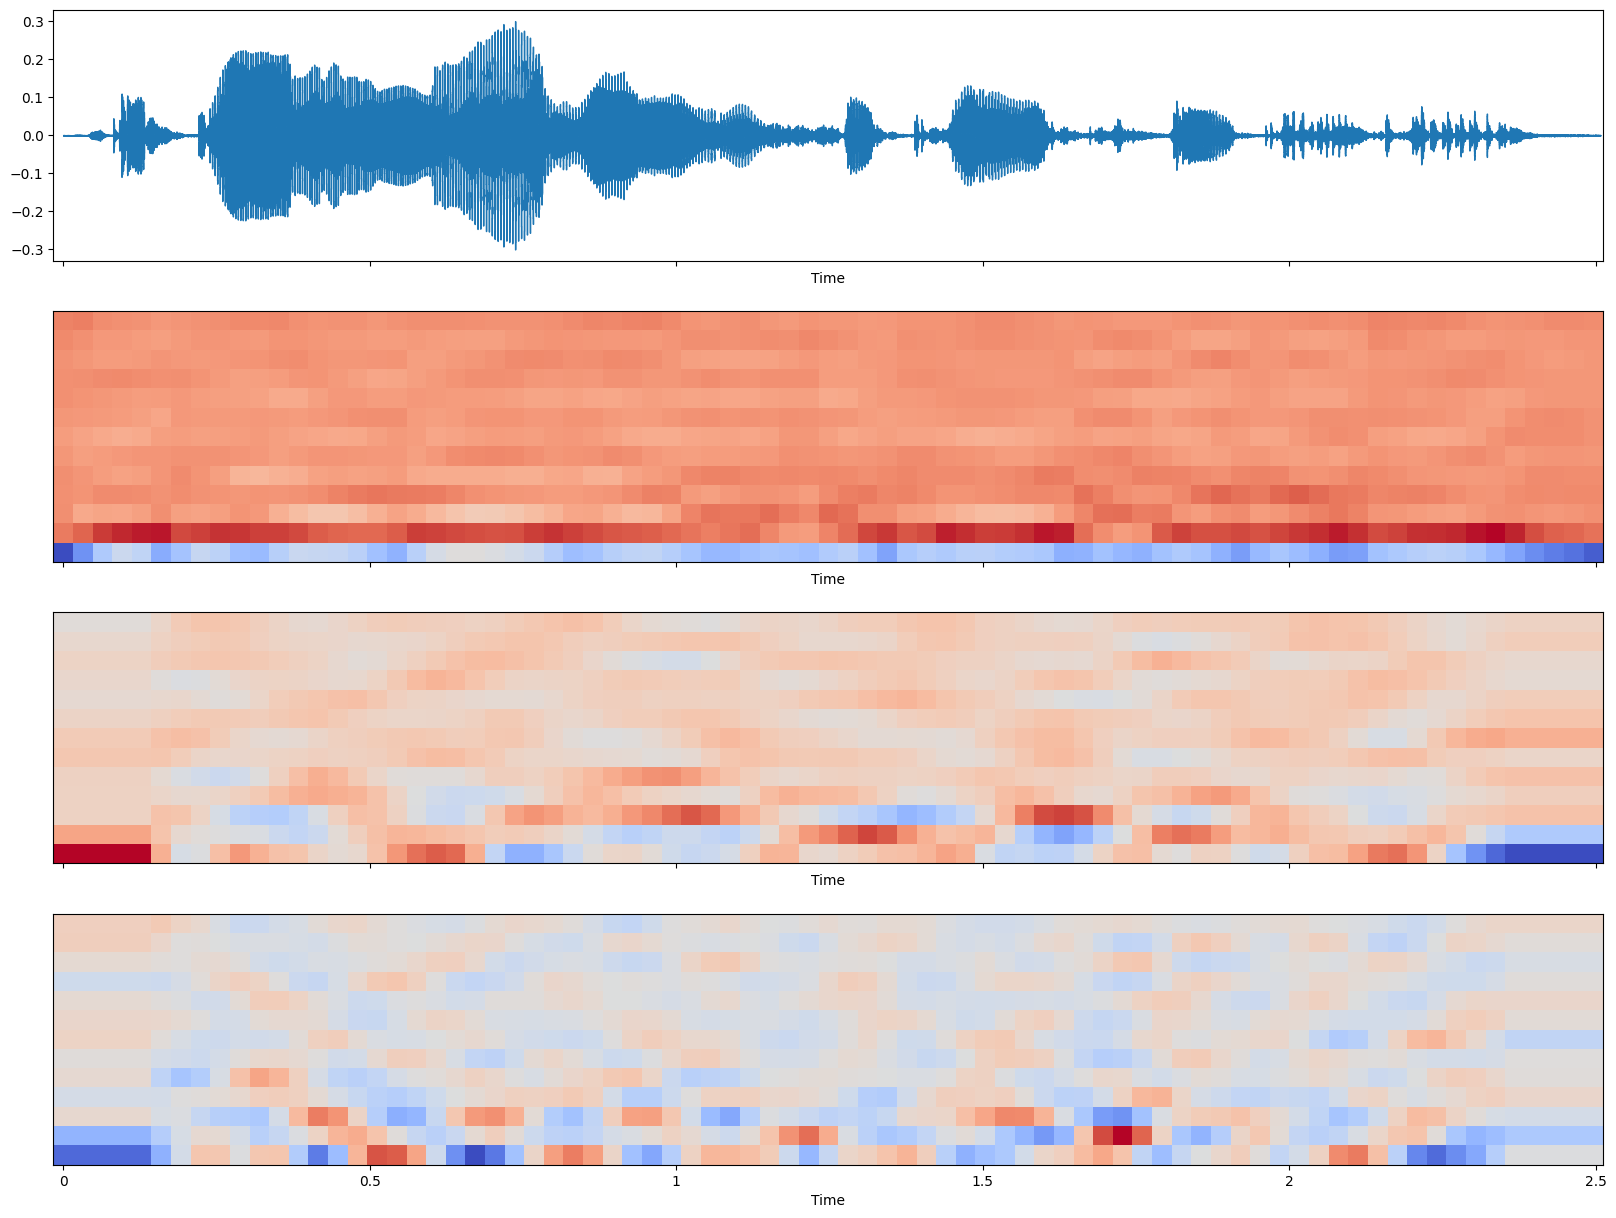

In [4]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize = (20, 15))

librosa.display.waveshow(sig, sr=SAMPLE_RATE, ax=ax[0])  # put signal in row 0, 
librosa.display.specshow(mfccs, sr=SAMPLE_RATE ,x_axis='time', ax=ax[1]) # mfccs in row 1
librosa.display.specshow(delta_mfccs, sr=SAMPLE_RATE ,x_axis='time', ax=ax[2]) # deltas mfccs in row 2
librosa.display.specshow(delta2_mfccs, sr=SAMPLE_RATE ,x_axis='time', ax=ax[3]) # delta-deltas mfccs in row 3

After the selection of MFCCs as my feature set, I had to decide what kind of classifier to use. I could use trandiotinal machine learning algorithms such as KNN. Although, deep neural networks achieve highest accuracy, so I followed this path. 

I choose as classifier a DNN with LSTM layers. LSTM networks are well-suited to classifying, processing and making predictions based on time series data. Long short-term memory (LSTM) network has been proved to be effective with temporal features because they can handle the sequence of the features using a type of memory.

LSTM expects the feature vectors to be in the same shape. This means that in order to use a LSTM architecture the feature extraction must occur using fixed size time windows of the audio files. 

However our audio files are not in the same length (duration). So I need to split each audio file in fixed time windows and extract the features for each segment. I choose to use 2 seconds time window without overlap.

So lets split the above waveform into 2 second time windows and extract the features

In [5]:
#Get the audio file's duration
duration = get_duration(sig, sr=SAMPLE_RATE)
print(f"The audio file's duration is {round(duration, 2)} seconds")

The audio file's duration is 2.51 seconds


So we expect only one segment after the signal's splitting

In [6]:
WINDOW_SIZE = 2000 #milliseconds
WINDOW_STEP = 2000 #milliseconds, this means that we dont have overlap

segs = split_to_signals(sig, sr=SAMPLE_RATE, size=WINDOW_SIZE, slide=WINDOW_STEP)
print(f"The number of audio segments after signal splitting is: {len(segs)}")

The number of audio segments after signal splitting is: 1


Lets extract the mfccs, deltas and delta-deltas features for the segment of 2 seconds, and concat them in order to see the shape of the feature vectors which describe the audio segment.

In [7]:
N_FFT = 128 #milliseconds
HOP_LENGTH = 32 #milliseconds
NUM_MFCC = 13

mfccs, delta_mfccs, delta2_mfccs = extract_features(
    sig = segs[0],
    sr = SAMPLE_RATE,
    num_mfcc=NUM_MFCC,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH
)

#vertical feature stack
mfccs_conc = np.vstack((mfccs, delta_mfccs))
mfccs_conc = np.vstack((mfccs_conc, delta2_mfccs))
print(mfccs_conc.shape)

(39, 63)


Finally, as we can see then the time window is represented by 63 timesteps of 39 features.

You can use the flows/audio_feature_extraction.py to extract the above mentioned audio features for fixed size time windows for a set of audio files

#### Setting up the experiment

Our target is to create a speaker indentification system using the extracted features from all the audio files of SOLO dataset. 
This means that we need to use some data from all the users in the training and use the rest of them in testing in order to see our system's evaluation.
Altough in order out experiment to be valid, we must secure that segments of the same audio file will not be in the training and in the testing at the same time. 

Furthermore we want the evaluate our model with each audio file and not only with a small part of the dataset. 
For this reason I used a GroupKFold experimentation setup, with 5 folds without overlap. 
Each fold represents 20% of the initial dataset.
The groups are created using the filename as a key. 
So, audio segments of the same audio file are always in the same fold, avoiding any type
of data leakage between train and test set

Furthermore, with GroupKFold, we secure that all the audio files will be in testing position at the end,
because with each iteration 4 folds are used for training and the rest one for testing in a circular manner

Finally, I wanted to have a validation set for monitoring the model training. I followed the same method
and I used the above 4 folds for performing a second GroupKFold with only one iteration (5 splits, 4 for training and 1 for validation)

The code for all these can be found in flows/train_speaker_identification.py

In the below cell we can see the results of the method.

In [8]:
results_path = OUTPUT_PATH.joinpath('step1_results_groupkfold.pickle')
results = load_pickle(results_path)
results

,source_file,label,prediction,frf01,frf02,frf03,frf04,frm01,frm02,frm03,...,irm07,irm08,irm09,irm10,irm11,irm12,irm13,irm14,irm15,irm16
0,frf01_s26_solo.wav,frf01,frf01,0.885940,6.132318e-07,0.000233,0.000087,4.078072e-05,4.900220e-07,0.000022,...,0.000439,0.000002,0.000111,0.000003,5.979278e-08,0.000005,0.000005,4.510842e-07,4.261875e-06,0.000090
1,frf01_s05_solo.wav,frf01,frf01,0.888247,1.055913e-06,0.000438,0.000357,7.016539e-05,1.103099e-06,0.000056,...,0.000520,0.000005,0.000059,0.000005,1.370085e-07,0.000012,0.000007,1.472076e-06,1.823699e-05,0.000213
2,frf01_s15_solo.wav,frf01,frf01,0.433206,8.839424e-05,0.015231,0.000231,3.892996e-04,1.235841e-05,0.000277,...,0.003079,0.000015,0.001628,0.000160,9.397240e-07,0.000038,0.000068,9.721489e-06,1.394621e-04,0.000522
3,frf01_s15_solo.wav,frf01,frf01,0.958315,5.102234e-07,0.000239,0.000095,1.919931e-05,6.069179e-07,0.000035,...,0.000258,0.000002,0.000081,0.000001,4.208601e-08,0.000009,0.000005,9.095082e-07,4.217975e-06,0.000087
4,frf01_s21_solo.wav,frf01,frf01,0.977417,1.024319e-06,0.000512,0.000164,2.431336e-05,8.514496e-07,0.000028,...,0.000288,0.000005,0.000130,0.000003,1.052184e-07,0.000022,0.000009,2.626815e-06,1.154021e-05,0.000110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,irf07_s33_solo.wav,irf07,irf07,0.000101,4.859465e-05,0.000424,0.000815,2.668389e-06,2.698757e-06,0.000074,...,0.000014,0.000014,0.000009,0.000016,4.818301e-05,0.000008,0.000085,6.336199e-06,1.100272e-06,0.000354
752,irf07_s33_solo.wav,irf07,irf07,0.000077,2.358168e-04,0.000009,0.000117,6.387134e-08,9.083754e-07,0.000010,...,0.000003,0.000009,0.000001,0.000007,3.074585e-05,0.000003,0.000015,1.115939e-06,5.272011e-08,0.000123
753,irf07_s07_solo.wav,irf07,irf07,0.000224,1.016955e-04,0.000019,0.000116,4.528611e-07,8.695941e-07,0.000045,...,0.000009,0.000007,0.000003,0.000003,3.702482e-05,0.000004,0.000035,2.409870e-06,1.451960e-07,0.000239
754,irf07_s25_solo.wav,irf07,irf07,0.000075,7.434356e-05,0.000009,0.000058,1.098735e-07,1.163438e-06,0.000022,...,0.000003,0.000008,0.000001,0.000006,3.327650e-05,0.000003,0.000023,1.143281e-06,6.923295e-08,0.000150


Plot the confusion matrix (normalized and not normlized values)

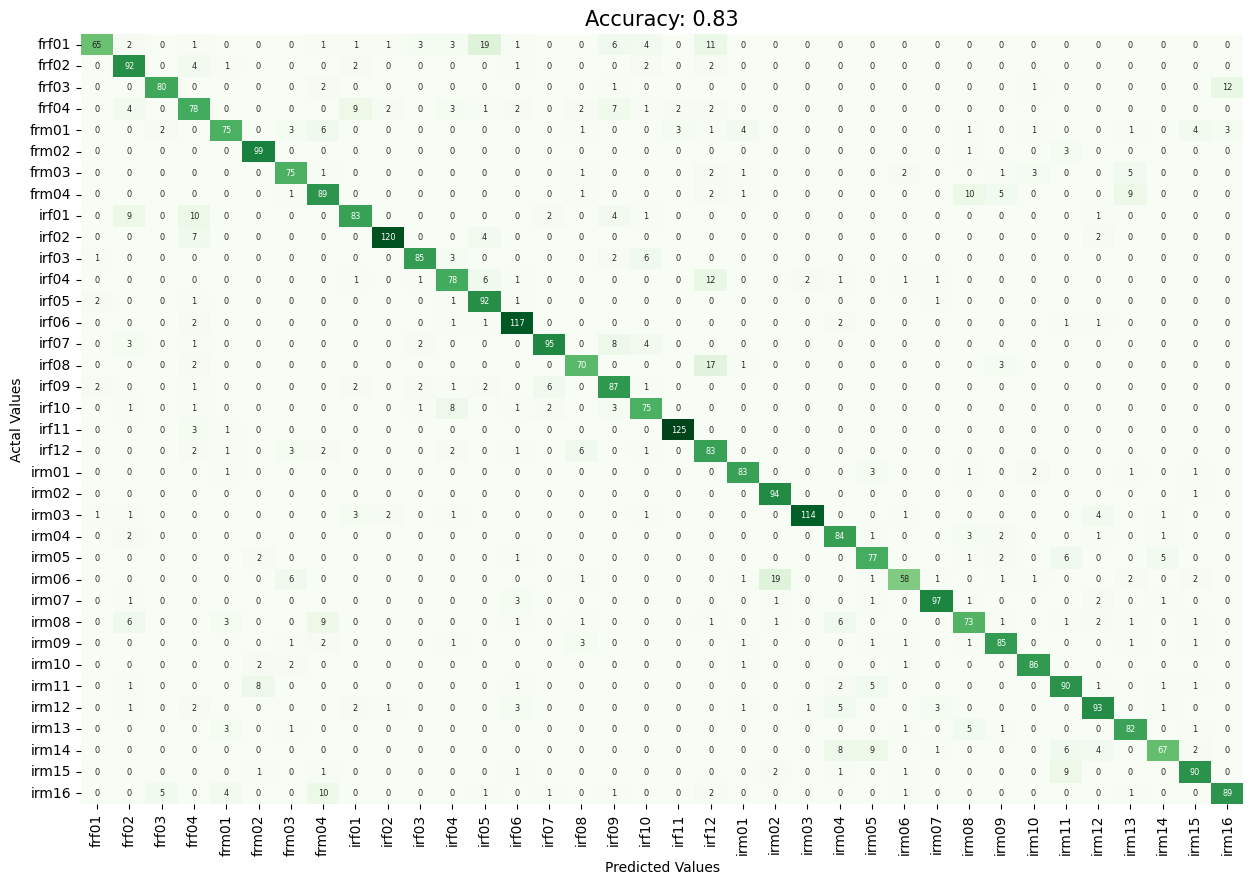

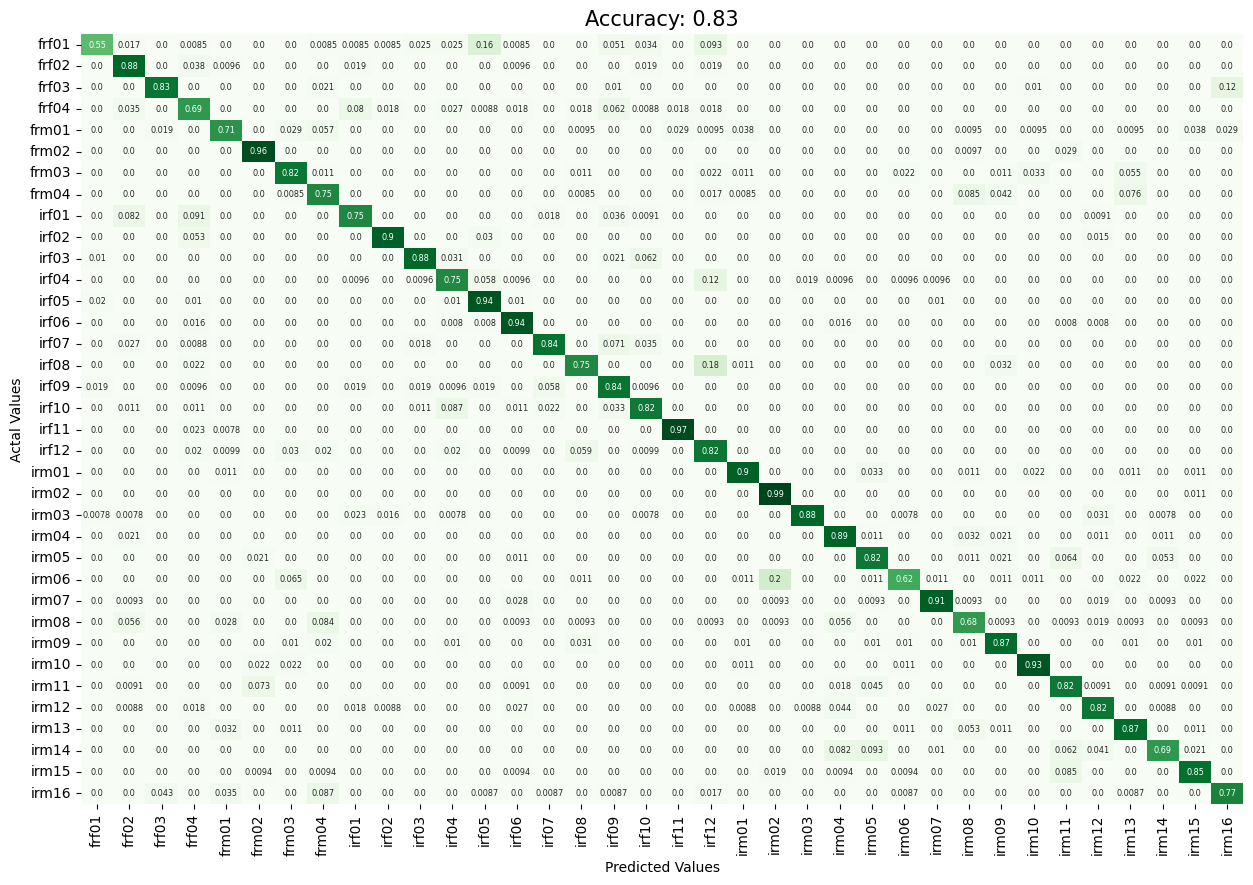

In [9]:
plot_confusion_matrix(results['label'].values, results['prediction'].values, norm=False, fullpath=OUTPUT_PATH.joinpath('step1_cm.jpg'))
plot_confusion_matrix(results['label'].values, results['prediction'].values, norm=True, fullpath=OUTPUT_PATH.joinpath('step1_normalized_cm.jpg'))

### 2. Assuming that you needed to apply the learned rules / models on the Fast Speech condition dataset, without having that (test) dataset beforehand, what you would do?

Regarding this task, it is each very easy to guess that the pretrained model using the SOLO dataset will have a low performance predicting the FAST dataset. Let's confirm it. 
Steps:
 1. Extract features for the FAST dataset using the flows/audio_feature_extraction.py
 2. Use the pretrained model in SOLO dataset to predict the FAST dataset using flows/predict_speaker.py

The results are the following:

In [10]:
results_path = OUTPUT_PATH.joinpath('step2_results.pickle')
results = load_pickle(results_path)
results

,source_file,label,prediction,frf01,frf02,frf03,frf04,frm01,frm02,frm03,...,irm07,irm08,irm09,irm10,irm11,irm12,irm13,irm14,irm15,irm16
0,frf01_s22_fast.wav,frf01,frm03,0.000145,4.407820e-06,0.004015,0.000067,0.026620,0.000093,0.792364,...,0.000284,0.000903,0.015497,0.064390,0.000004,0.000342,0.006234,3.299328e-06,0.000744,0.002798
1,frf01_s23_fast.wav,frf01,irm02,0.000105,3.269926e-05,0.001338,0.000155,0.008603,0.000834,0.272991,...,0.000953,0.001860,0.069385,0.028138,0.000031,0.000450,0.004641,8.359820e-06,0.006795,0.002047
2,frf01_s28_fast.wav,frf01,frm03,0.000393,7.713390e-07,0.000092,0.000036,0.000358,0.000028,0.843279,...,0.000218,0.000120,0.049191,0.000342,0.000010,0.000055,0.001192,1.759065e-06,0.000524,0.000522
3,frf01_s29_fast.wav,frf01,irm09,0.000040,1.328361e-05,0.000552,0.000022,0.003206,0.000144,0.360955,...,0.000128,0.003375,0.438302,0.000624,0.000011,0.000138,0.006390,6.719857e-07,0.003680,0.000452
4,frf01_s16_fast.wav,frf01,irm02,0.000057,4.902339e-05,0.002096,0.000186,0.017714,0.000305,0.097648,...,0.000288,0.003282,0.020047,0.032533,0.000014,0.000264,0.002777,3.901835e-06,0.003350,0.001857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,irf07_f01_fast.wav,irf07,frm03,0.000099,9.395004e-06,0.003364,0.000120,0.006091,0.000489,0.793438,...,0.000244,0.000696,0.039383,0.048112,0.000008,0.000308,0.015413,5.721916e-06,0.006623,0.002152
2720,irf07_f01_fast.wav,irf07,frm03,0.000078,8.408790e-06,0.001339,0.000050,0.004997,0.000288,0.855290,...,0.000119,0.000628,0.030332,0.012317,0.000005,0.000097,0.050241,9.021434e-06,0.007094,0.000423
2721,irf07_f01_fast.wav,irf07,irm02,0.000116,1.894377e-04,0.000508,0.000078,0.006474,0.001320,0.154473,...,0.000970,0.003084,0.212640,0.002842,0.000526,0.000357,0.016777,1.586895e-05,0.059944,0.000523
2722,irf07_f01_fast.wav,irf07,frm03,0.000060,3.029780e-05,0.003317,0.000162,0.017517,0.000406,0.490180,...,0.000505,0.000556,0.039350,0.088654,0.000023,0.000337,0.010503,6.299671e-06,0.016029,0.001253


Plot the confusion matrix (normalized and not normlized values)

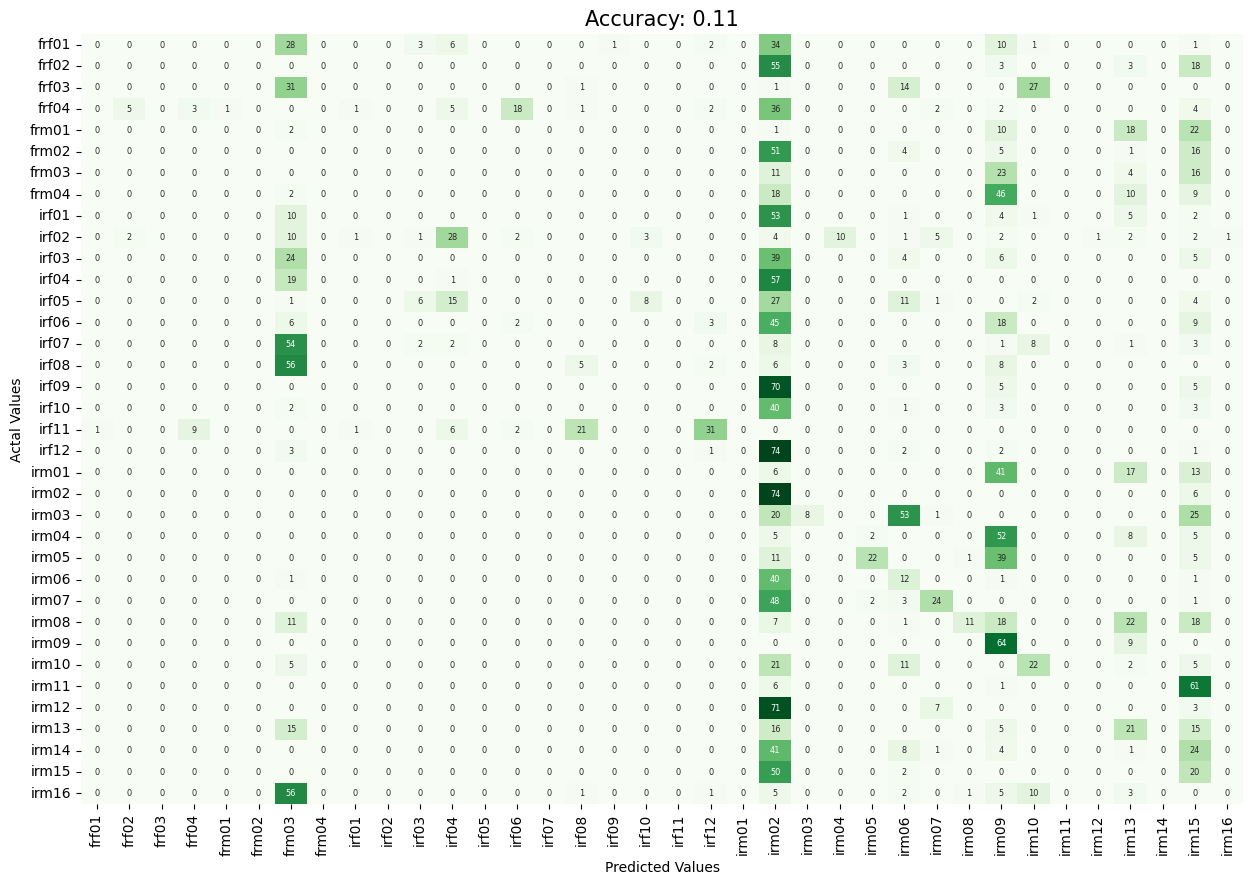

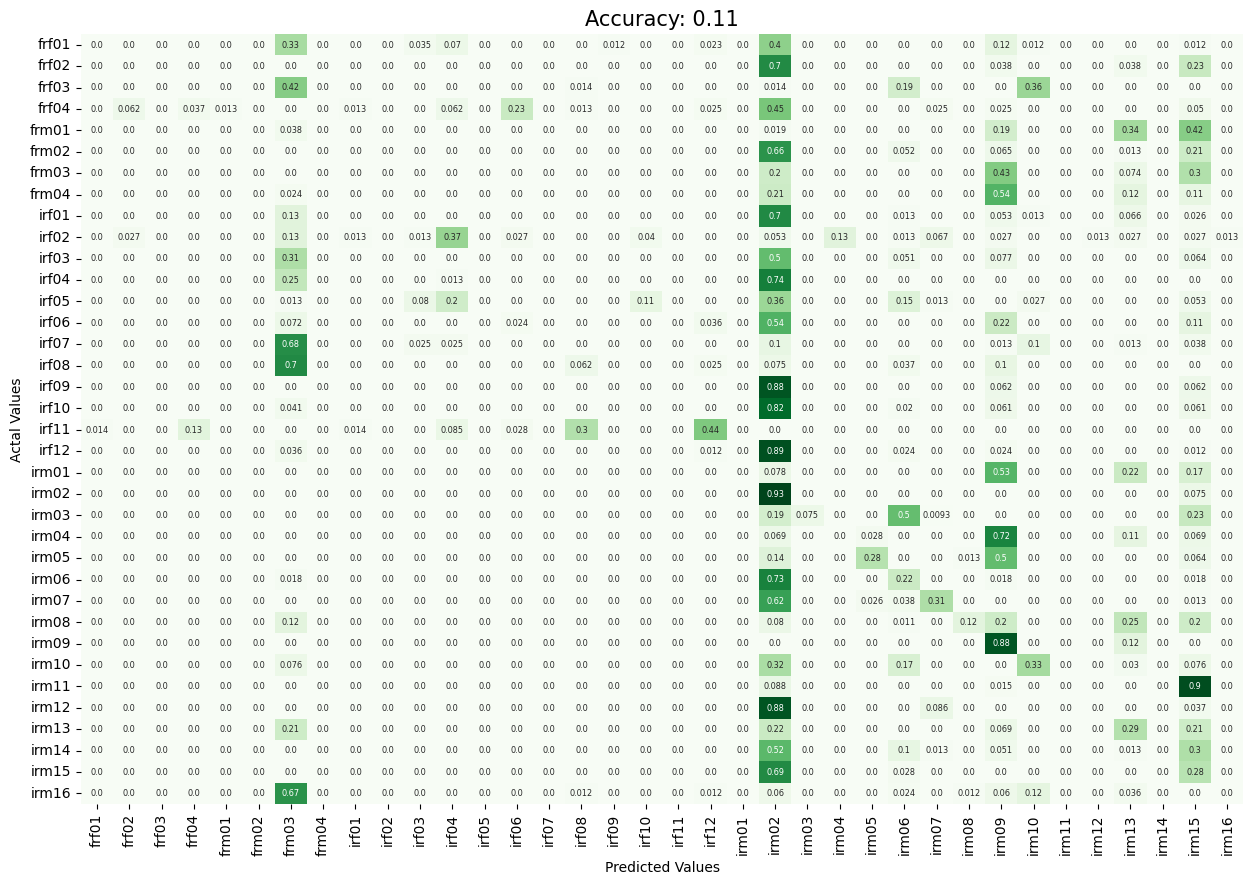

In [11]:
plot_confusion_matrix(results['label'].values, results['prediction'].values, norm=False, fullpath=OUTPUT_PATH.joinpath('step2_cm.jpg'))
plot_confusion_matrix(results['label'].values, results['prediction'].values, norm=True, fullpath=OUTPUT_PATH.joinpath('step2_normalized_cm.jpg'))

The reason the model didn't achieve well is very clear. The pretrained model is an LSTM architecture that was trained to recognize the speaker who talks with a normal tempo. Talking very fast affects the sequence of MFCCs features and the model fails because expects the features with different sequences or in other words fewer phonemes in a fixed-size time window.

So, to solve that problem we need to find a different solution in which time doesn't play a role.
Such a solution would be to use the wav2vec 2.0,

Wav2vec 2.0 is a framework that achieves state-of-art results in ASR tasks regardless of how fast a user speaks or the pauses in his talk 
The idea behind this is that since the model achieves very good results in speech-to-text problem it means that in some intermediate layer of it, the model captures the user's 'voice' in a perfect way.
A wav2vec model consists of a feature encoder with 7 blocks of CNN layers followed by a transformer encoder with 24 blocks of layers
So, we can exploit its potential, extracting audio representations from an intermediate layer as I did during my thesis (dealing with speech emotion recognition) achieving state-of-art results.

### 3. Another important task is to perform gender classification on the same datasets, but there are no available labels. You can use the entirety of data you have at your disposal.

In general, women speak at a higher pitch—about an octave higher than men. An adult woman's average range is from 165 to 255 Hz, while a man's is 85 to 155 Hz.

Due to the lack of gender labels I will try to classify the gender using the fundemental frequency of the corresponding audio file using a statistical rule. For the extraction of the fundamendal frequency I used an algorithm called Probabilistic YIN (PYIN) which is implemented by librosa library. 

PYIN is a modification of the YIN algorithm for the estimation of the fundamental frequency (F0) but with better results. The first stage of PYIN follows the same steps as the original YIN algorithm, differing only in the thresholding stage, where it assumes a threshold distribution, in contrast to YIN, which relies on a single threshold. 

The PYIN method is divided into two stages: 
- frame-wise extraction of multiple pitch candidates with associated probabilities 
- these probabilities are used  as emission probabilities in a Hidden Markov Model which trys to find the likely pitch sequence given the emissions


Lets extract the fundamental frequency of an audio file from SOLO dataset.
I will use the librosa's default parameters for PYIN algorithm but I will search for F0 between 50 and 300 Hz

In [12]:
SAMPLE_RATE = 22050

#Load audio file
sig = audio_load(filepath=audiofiles_solo[0], sr=SAMPLE_RATE)

#Apply the PYIN algorithm for extracting the F0 of the signal
f0, voiced_flag, voiced_probs = librosa.pyin(
    sig,
    fmin=50,
    fmax=300,
    sr=SAMPLE_RATE
)

times = librosa.times_like(f0)

Overlay F0 over a spectrogram

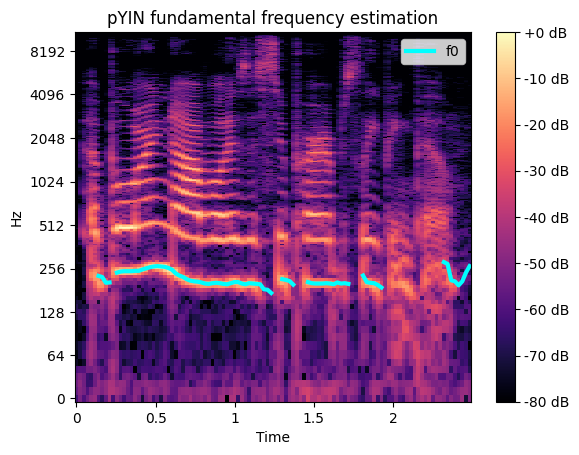

In [13]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(sig)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

As we can see from the plot the F0 values are about 200Hz which means that the voice belongs to a woman.

In general, for predicting the gender from fundamendal frequency we need to set a statistical rule. As I mentioned above about the pitch, an adult woman's average range is from 165 to 255 Hz, while a man's is 85 to 155 Hz. So we can set a threshold at 160 Hz. So I compared this threshold with the most representative value of F0, which is the median value of the vector. So:
- If F0 > 160Hz then the speaker is a female
- If F0 <= 160Hz then the speaker is a male

Using the /flows/gender_classification.py, a dataset is created calculating the median and mean value of F0 for each audio file of the dataset.
Also, I created a mapping dictionary between user name and its gender from dataset's description pdf file for evaluating my method.

For this step, I used both SOLO and FAST dataset.

Let's load the extracted dataset.

In [14]:
dataset_path = OUTPUT_PATH.joinpath('step3_dataset.pickle')
dataset = load_pickle(dataset_path)
dataset

,filename,corpus,user,mean_f0,median_f0,gender
0,frf01_s22_fast.wav,fast,frf01,210.045345,208.252431,female
1,frf01_s23_fast.wav,fast,frf01,204.573410,208.252431,female
2,frf01_s28_fast.wav,fast,frf01,211.495902,205.274462,female
3,frf01_s29_fast.wav,fast,frf01,198.649102,194.869191,female
4,frf01_s16_fast.wav,fast,frf01,215.020305,210.672207,female
...,...,...,...,...,...,...
2657,irf07_s17_solo.wav,solo,irf07,173.052401,163.391545,female
2658,irf07_s28_solo.wav,solo,irf07,169.969117,164.338063,female
2659,irf07_s29_solo.wav,solo,irf07,164.638423,154.667779,female
2660,irf07_f04_solo.wav,solo,irf07,162.165215,158.740105,female


Lets plot a grouped boxplot of median f0 distribution across male and female genders

<AxesSubplot: xlabel='gender', ylabel='median_f0'>

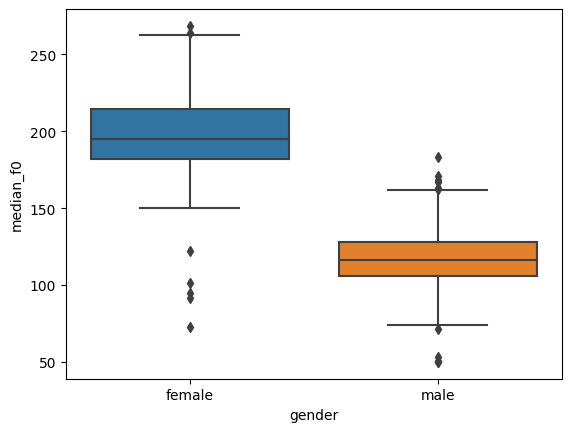

In [15]:
sns.boxplot(x='gender', y='median_f0', data=dataset)

The above boxplot confirms that the rule I set will recognize the gender with high accuracy

Lets apply the rule I set and see the results

In [16]:
#Predict gender based on rule
threshold = 160 #Hz
dataset["prediction"] = dataset["median_f0"].apply(lambda x: 'female' if x>threshold else 'male')

Plot confusion matrix

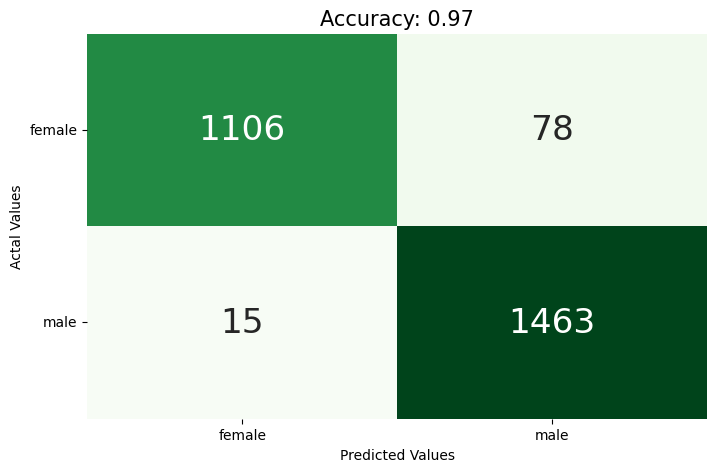

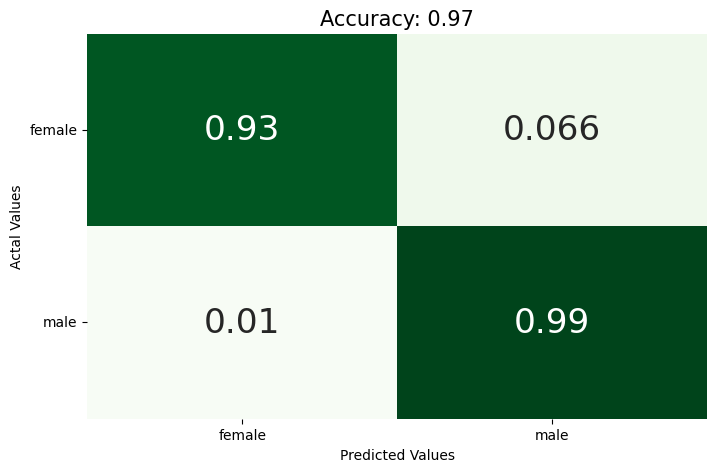

In [17]:
plot_confusion_matrix(dataset['gender'].values, dataset['prediction'].values, norm=False, fullpath=OUTPUT_PATH.joinpath('step3_cm.jpg'), figsize=(8,5))
plot_confusion_matrix(dataset['gender'].values, dataset['prediction'].values, norm=True, fullpath=OUTPUT_PATH.joinpath('step3_normalized_cm.jpg'), figsize=(8,5))

## Thank you in advance. Good luck!